# Replicate

>[Replicate](https://replicate.com/blog/machine-learning-needs-better-tools) runs machine learning models in the cloud. We have a library of open-source models that you can run with a few lines of code. If you're building your own machine learning models, Replicate makes it easy to deploy them at scale.

This example goes over how to use LangChain to interact with `Replicate` [models](https://replicate.com/explore)

## Setup

To run this notebook, you'll need to create a [replicate](https://replicate.com) account and install the [replicate python client](https://github.com/replicate/replicate-python).

In [ ]:
!pip install replicate

In [2]:
# get a token: https://replicate.com/account

from getpass import getpass

REPLICATE_API_TOKEN = getpass()

 ········


In [3]:
import os

os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN

In [4]:
from langchain.llms import Replicate
from langchain import PromptTemplate, LLMChain

## Calling a model

Find a model on the [replicate explore page](https://replicate.com/explore), and then paste in the model name and version in this format: model_name/version

For example, for this [dolly model](https://replicate.com/replicate/dolly-v2-12b), click on the API tab. The model name/version would be: `replicate/dolly-v2-12b:ef0e1aefc61f8e096ebe4db6b2bacc297daf2ef6899f0f7e001ec445893500e5`

Only the `model` param is required, but we can add other model params when initializing.

For example, if we were running stable diffusion and wanted to change the image dimensions:

```
Replicate(model="stability-ai/stable-diffusion:db21e45d3f7023abc2a46ee38a23973f6dce16bb082a930b0c49861f96d1e5bf", input={'image_dimensions': '512x512'})
```
                       
*Note that only the first output of a model will be returned.*

In [5]:
llm = Replicate(model="replicate/dolly-v2-12b:ef0e1aefc61f8e096ebe4db6b2bacc297daf2ef6899f0f7e001ec445893500e5")

In [4]:
prompt = """
Answer the following yes/no question by reasoning step by step. 
Can a dog drive a car?
"""
llm(prompt)

'The legal driving age of dogs is 2. Cars are designed for humans to drive. Therefore, the final answer is yes.'

We can call any replicate model using this syntax. For example, we can call stable diffusion.

In [7]:
text2image = Replicate(model="stability-ai/stable-diffusion:db21e45d3f7023abc2a46ee38a23973f6dce16bb082a930b0c49861f96d1e5bf", 
                       input={'image_dimensions': '512x512'})

In [8]:
image_output = text2image("A cat riding a motorcycle by Picasso")
image_output

'https://replicate.delivery/pbxt/Cf07B1zqzFQLOSBQcKG7m9beE74wf7kuip5W9VxHJFembefKE/out-0.png'

The model spits out a URL. Let's render it.

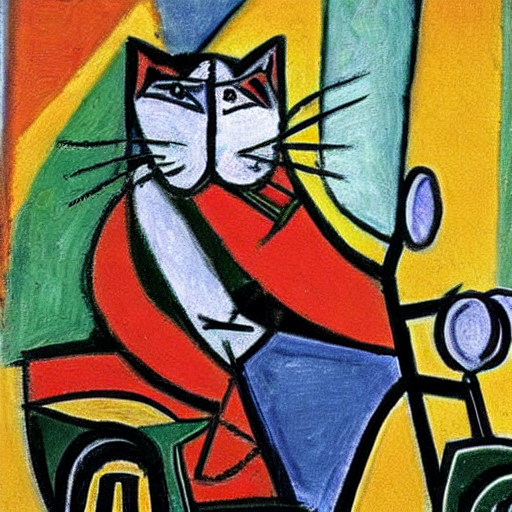

In [9]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get(image_output)
img = Image.open(BytesIO(response.content))

img

## Chaining Calls
The whole point of langchain is to... chain! Here's an example of how do that.

In [10]:
from langchain.chains import SimpleSequentialChain

First, let's define the LLM for this model as a flan-5, and text2image as a stable diffusion model.

In [21]:
dolly_llm = Replicate(model="replicate/dolly-v2-12b:ef0e1aefc61f8e096ebe4db6b2bacc297daf2ef6899f0f7e001ec445893500e5")
text2image = Replicate(model="stability-ai/stable-diffusion:db21e45d3f7023abc2a46ee38a23973f6dce16bb082a930b0c49861f96d1e5bf")

First prompt in the chain

In [22]:
prompt = PromptTemplate(
    input_variables=["product"],
    template="What is a good name for a company that makes {product}?",
)

chain = LLMChain(llm=dolly_llm, prompt=prompt)

Second prompt to get the logo for company description

In [23]:
second_prompt = PromptTemplate(
    input_variables=["company_name"],
    template="Write a description of a logo for this company: {company_name}",
)
chain_two = LLMChain(llm=dolly_llm, prompt=second_prompt)

Third prompt, let's create the image based on the description output from prompt 2

In [24]:
third_prompt = PromptTemplate(
    input_variables=["company_logo_description"],
    template="{company_logo_description}",
)
chain_three = LLMChain(llm=text2image, prompt=third_prompt)

Now let's run it!

In [25]:
# Run the chain specifying only the input variable for the first chain.
overall_chain = SimpleSequentialChain(chains=[chain, chain_two, chain_three], verbose=True)
catchphrase = overall_chain.run("colorful socks")
print(catchphrase)



> Entering new SimpleSequentialChain chain...
novelty socks
todd & co.
https://replicate.delivery/pbxt/BedAP1PPBwXFfkmeD7xDygXO4BcvApp1uvWOwUdHM4tcQfvCB/out-0.png

> Finished chain.
https://replicate.delivery/pbxt/BedAP1PPBwXFfkmeD7xDygXO4BcvApp1uvWOwUdHM4tcQfvCB/out-0.png


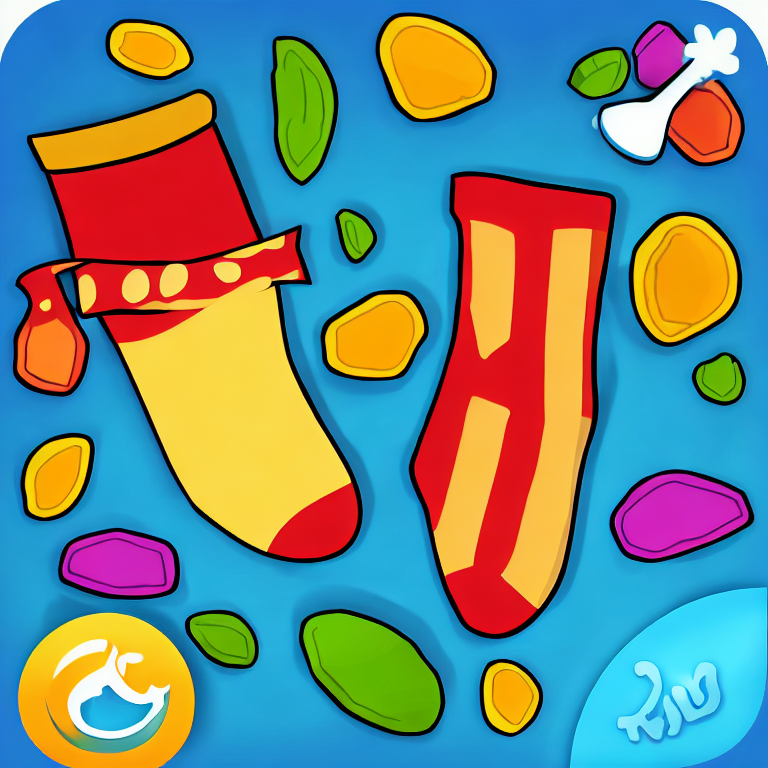

In [70]:
response = requests.get("https://replicate.delivery/pbxt/eq6foRJngThCAEBqse3nL3Km2MBfLnWQNd0Hy2SQRo2LuprCB/out-0.png")
img = Image.open(BytesIO(response.content))
img